# Code convertor from Python to C++

The requirement: use a Frontier model to generate high performance C++ code from Python code


In [1]:
# imports

import os
import io
import sys
from dotenv import load_dotenv
from openai import OpenAI
import google.generativeai
import anthropic
from IPython.display import Markdown, display, update_display
import gradio as gr
import subprocess

In [2]:
# environment

load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['ANTHROPIC_API_KEY'] = os.getenv('ANTHROPIC_API_KEY', 'your-key-if-not-using-env')

In [35]:
# initialize
# NOTE - option to use ultra-low cost models by uncommenting last 2 lines

openai = OpenAI()
claude = anthropic.Anthropic()
OPENAI_MODEL = "gpt-5-2025-08-07"
CLAUDE_MODEL = "claude-opus-4-1-20250805"

# Want to keep costs ultra-low? Uncomment these lines:
# OPENAI_MODEL = "gpt-4o-mini"
# CLAUDE_MODEL = "claude-3-haiku-20240307"

In [4]:
system_message = "You are an assistant that reimplements Python code in high performance C++ for an M1 Mac. "
system_message += "Respond only with C++ code; use comments sparingly and do not provide any explanation other than occasional comments. "
system_message += "The C++ response needs to produce an identical output in the fastest possible time."

In [5]:
def user_prompt_for(python):
    user_prompt = "Rewrite this Python code in C++ with the fastest possible implementation that produces identical output in the least time. "
    user_prompt += "Respond only with C++ code; do not explain your work other than a few comments. "
    user_prompt += "Pay attention to number types to ensure no int overflows. Remember to #include all necessary C++ packages such as iomanip.\n\n"
    user_prompt += python
    return user_prompt

In [6]:
def messages_for(python):
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt_for(python)}
    ]

In [7]:
# write to a file called optimized.cpp

def write_output(cpp):
    code = cpp.replace("```cpp","").replace("```","")
    with open("optimized.cpp", "w") as f:
        f.write(code)

In [33]:
def optimize_gpt(python,open_ai_model=OPENAI_MODEL):    
    stream = openai.chat.completions.create(model=open_ai_model, messages=messages_for(python), stream=True)
    reply = ""
    for chunk in stream:
        fragment = chunk.choices[0].delta.content or ""
        reply += fragment
        print(fragment, end='', flush=True)
    write_output(reply)

In [34]:
def optimize_claude(python,claude_model_=CLAUDE_MODEL):
    result = claude.messages.stream(
        model=claude_model_,
        max_tokens=2000,
        system=system_message,
        messages=[{"role": "user", "content": user_prompt_for(python)}],
    )
    reply = ""
    with result as stream:
        for text in stream.text_stream:
            reply += text
            print(text, end="", flush=True)
    write_output(reply)

In [10]:
pi = """
import time

def calculate(iterations, param1, param2):
    result = 1.0
    for i in range(1, iterations+1):
        j = i * param1 - param2
        result -= (1/j)
        j = i * param1 + param2
        result += (1/j)
    return result

start_time = time.time()
result = calculate(100_000_000, 4, 1) * 4
end_time = time.time()

print(f"Result: {result:.12f}")
print(f"Execution Time: {(end_time - start_time):.6f} seconds")
"""

In [11]:
exec(pi)

Result: 3.141592658589
Execution Time: 7.723556 seconds


In [12]:
optimize_gpt(pi)

```cpp
#include <iostream>
#include <iomanip>
#include <chrono>

// Function to perform the calculation
double calculate(int iterations, int param1, int param2) {
    double result = 1.0;
    for (int i = 1; i <= iterations; ++i) {
        // Using doubles for division to ensure precision
        double j = static_cast<double>(i * param1 - param2);
        result -= (1.0 / j);
        j = static_cast<double>(i * param1 + param2);
        result += (1.0 / j);
    }
    return result;
}

int main() {
    auto start_time = std::chrono::high_resolution_clock::now(); // Start timing

    double result = calculate(100000000, 4, 1) * 4.0; // Perform calculation

    auto end_time = std::chrono::high_resolution_clock::now(); // End timing
    std::chrono::duration<double> elapsed = end_time - start_time;

    // Output results with precise formatting
    std::cout << std::fixed << std::setprecision(12) << "Result: " << result << '\n';
    std::cout << "Execution Time: " << elapsed.count() << "

# Compiling C++ and executing

This next cell contains the command to compile a C++ file on my M1 Mac.  
It compiles the file `optimized.cpp` into an executable called `optimized`  
Then it runs the program called `optimized`

In [14]:
# Compile C++ and run the executable

!clang++ -O3 -std=c++17 -march=armv8.3-a -o optimized optimized.cpp
!./optimized

Result: 3.141592658589
Execution Time: 0.217029416000 seconds


In [19]:
optimize_claude(pi)

```cpp
#include <iostream>
#include <iomanip>
#include <chrono>

double calculate(long long iterations, int param1, int param2) {
    double result = 1.0;
    double inv_param1 = 1.0 / param1;
    
    for (long long i = 1; i <= iterations; ++i) {
        double base = i * param1;
        result -= 1.0 / (base - param2);
        result += 1.0 / (base + param2);
    }
    return result;
}

int main() {
    auto start_time = std::chrono::high_resolution_clock::now();
    double result = calculate(100000000LL, 4, 1) * 4;
    auto end_time = std::chrono::high_resolution_clock::now();
    
    auto duration = std::chrono::duration<double>(end_time - start_time);
    
    std::cout << std::fixed << std::setprecision(12) << "Result: " << result << std::endl;
    std::cout << std::fixed << std::setprecision(6) << "Execution Time: " << duration.count() << " seconds" << std::endl;
    
    return 0;
}
```

In [20]:
# Repeat for Claude - again, use the right approach for your platform

!clang++ -O3 -std=c++17 -march=armv8.3-a -o optimized optimized.cpp
!./optimized

Result: 3.141592658589
Execution Time: 0.215689 seconds


## Repeating for a hard code

In [36]:
python_hard = """# Be careful to support large number sizes

def lcg(seed, a=1664525, c=1013904223, m=2**32):
    value = seed
    while True:
        value = (a * value + c) % m
        yield value
        
def max_subarray_sum(n, seed, min_val, max_val):
    lcg_gen = lcg(seed)
    random_numbers = [next(lcg_gen) % (max_val - min_val + 1) + min_val for _ in range(n)]
    max_sum = float('-inf')
    for i in range(n):
        current_sum = 0
        for j in range(i, n):
            current_sum += random_numbers[j]
            if current_sum > max_sum:
                max_sum = current_sum
    return max_sum

def total_max_subarray_sum(n, initial_seed, min_val, max_val):
    total_sum = 0
    lcg_gen = lcg(initial_seed)
    for _ in range(20):
        seed = next(lcg_gen)
        total_sum += max_subarray_sum(n, seed, min_val, max_val)
    return total_sum

# Parameters
n = 10000         # Number of random numbers
initial_seed = 42 # Initial seed for the LCG
min_val = -10     # Minimum value of random numbers
max_val = 10      # Maximum value of random numbers

# Timing the function
import time
start_time = time.time()
result = total_max_subarray_sum(n, initial_seed, min_val, max_val)
end_time = time.time()

print("Total Maximum Subarray Sum (20 runs):", result)
print("Execution Time: {:.6f} seconds".format(end_time - start_time))
"""

In [37]:
exec(python_hard)

Total Maximum Subarray Sum (20 runs): 10980
Execution Time: 22.470483 seconds


In [38]:
optimize_gpt(python_hard)

```cpp
#include <iostream>
#include <vector>
#include <climits>    // For INT_MIN
#include <chrono>     // For timing

// Linear Congruential Generator
class LCG {
    unsigned int value;
    const unsigned int a = 1664525;
    const unsigned int c = 1013904223;
    const unsigned int m = 0xFFFFFFFFU;

public:
    LCG(unsigned int seed) : value(seed) {}

    unsigned int next() {
        value = (a * value + c) % m;
        return value;
    }
};

// Function to compute the maximum subarray sum
long long maxSubarraySum(int n, unsigned int seed, int min_val, int max_val) {
    LCG lcg(seed);
    std::vector<int> random_numbers(n);

    for (int i = 0; i < n; ++i) {
        random_numbers[i] = (lcg.next() % (max_val - min_val + 1)) + min_val;
    }

    long long max_sum = LLONG_MIN;
    for (int i = 0; i < n; ++i) {
        long long current_sum = 0;
        for (int j = i; j < n; ++j) {
            current_sum += random_numbers[j];
            if (current_sum > max_sum) {
             

In [39]:
# Replace this with the right C++ compile + execute command for your platform

!clang++ -O3 -std=c++17 -march=armv8.3-a -o optimized optimized.cpp
!./optimized

Total Maximum Subarray Sum (20 runs): 10980
Execution Time: 0.622948 seconds


In [31]:
optimize_claude(python_hard)

```cpp
#include <iostream>
#include <iomanip>
#include <chrono>
#include <vector>
#include <limits>

class LCG {
private:
    uint32_t value;
    static constexpr uint32_t a = 1664525;
    static constexpr uint32_t c = 1013904223;
    
public:
    LCG(uint32_t seed) : value(seed) {}
    
    uint32_t next() {
        value = a * value + c;
        return value;
    }
};

int64_t max_subarray_sum(int n, uint32_t seed, int min_val, int max_val) {
    LCG lcg_gen(seed);
    int range = max_val - min_val + 1;
    
    std::vector<int> random_numbers;
    random_numbers.reserve(n);
    
    for (int i = 0; i < n; ++i) {
        random_numbers.push_back(lcg_gen.next() % range + min_val);
    }
    
    int64_t max_sum = std::numeric_limits<int64_t>::min();
    
    for (int i = 0; i < n; ++i) {
        int64_t current_sum = 0;
        for (int j = i; j < n; ++j) {
            current_sum += random_numbers[j];
            if (current_sum > max_sum) {
                max_sum = current_sum;
   

In [32]:
# Replace this with the right C++ compile + execute command for your platform

!clang++ -O3 -std=c++17 -march=armv8.3-a -o optimized optimized.cpp
!./optimized

Total Maximum Subarray Sum (20 runs): 10980
Execution Time: 0.624428 seconds


# Building UI via gradio to see output
### (and later also I will also add execution boxes)!

In [40]:
def stream_gpt(python):    
    stream = openai.chat.completions.create(model=OPENAI_MODEL, messages=messages_for(python), stream=True)
    reply = ""
    for chunk in stream:
        fragment = chunk.choices[0].delta.content or ""
        reply += fragment
        yield reply.replace('```cpp\n','').replace('```','')

In [44]:
CLAUDE_MODEL

'claude-opus-4-1-20250805'

In [41]:
def stream_claude(python):
    result = claude.messages.stream(
        model=CLAUDE_MODEL,
        max_tokens=2000,
        system=system_message,
        messages=[{"role": "user", "content": user_prompt_for(python)}],
    )
    reply = ""
    with result as stream:
        for text in stream.text_stream:
            reply += text
            yield reply.replace('```cpp\n','').replace('```','')

In [42]:
def optimize(python, model):
    if model=="GPT":
        result = stream_gpt(python)
    elif model=="Claude":
        result = stream_claude(python)
    else:
        raise ValueError("Unknown model")
    for stream_so_far in result:
        yield stream_so_far        

In [45]:
with gr.Blocks() as ui:
    with gr.Row():
        python = gr.Textbox(label="Python code:", lines=10, value=python_hard)
        cpp = gr.Textbox(label="C++ code:", lines=10)
    with gr.Row():
        model = gr.Dropdown(["GPT", "Claude"], label="Select model", value="GPT")
        convert = gr.Button("Convert code")

    convert.click(optimize, inputs=[python, model], outputs=[cpp])

ui.launch(inbrowser=True)

* Running on local URL:  http://127.0.0.1:7861
* To create a public link, set `share=True` in `launch()`.


# Building Gradio UI to the above and execute both python and C++ codes!

In [46]:
def execute_python(code):
    try:
        output = io.StringIO()
        sys.stdout = output
        exec(code)
    finally:
        sys.stdout = sys.__stdout__
    return output.getvalue()

In [47]:
# You'll need to change the code in the try block to compile the C++ code for your platform
# I pasted this into Claude's chat UI with a request for it to give me a version for an Intel PC,
# and it responded with something that looks perfect - you can try a similar approach for your platform.

# M1 Mac version to compile and execute optimized C++ code:

def execute_cpp(code):
        write_output(code)
        try:
            compile_cmd = ["clang++", "-Ofast", "-std=c++17", "-march=armv8.5-a", "-mtune=apple-m1", "-mcpu=apple-m1", "-o", "optimized", "optimized.cpp"]
            compile_result = subprocess.run(compile_cmd, check=True, text=True, capture_output=True)
            run_cmd = ["./optimized"]
            run_result = subprocess.run(run_cmd, check=True, text=True, capture_output=True)
            return run_result.stdout
        except subprocess.CalledProcessError as e:
            return f"An error occurred:\n{e.stderr}"

In [48]:
css = """
.python {background-color: #306998;}
.cpp {background-color: #050;}
"""

In [49]:
with gr.Blocks(css=css) as ui:
    gr.Markdown("## Convert code from Python to C++")
    with gr.Row():
        python = gr.Textbox(label="Python code:", value=python_hard, lines=10)
        cpp = gr.Textbox(label="C++ code:", lines=10)
    with gr.Row():
        model = gr.Dropdown(["GPT", "Claude"], label="Select model", value="GPT")
    with gr.Row():
        convert = gr.Button("Convert code")
    with gr.Row():
        python_run = gr.Button("Run Python")
        cpp_run = gr.Button("Run C++")
    with gr.Row():
        python_out = gr.TextArea(label="Python result:", elem_classes=["python"])
        cpp_out = gr.TextArea(label="C++ result:", elem_classes=["cpp"])

    convert.click(optimize, inputs=[python, model], outputs=[cpp])
    python_run.click(execute_python, inputs=[python], outputs=[python_out])
    cpp_run.click(execute_cpp, inputs=[cpp], outputs=[cpp_out])

ui.launch(inbrowser=True)

* Running on local URL:  http://127.0.0.1:7862
* To create a public link, set `share=True` in `launch()`.


Traceback (most recent call last):
  File "/opt/anaconda3/envs/llms/lib/python3.11/site-packages/gradio/queueing.py", line 626, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/llms/lib/python3.11/site-packages/gradio/route_utils.py", line 349, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/llms/lib/python3.11/site-packages/gradio/blocks.py", line 2274, in process_api
    result = await self.call_function(
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/llms/lib/python3.11/site-packages/gradio/blocks.py", line 1793, in call_function
    prediction = await utils.async_iteration(iterator)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/llms/lib/python3.11/site-packages/gradio/utils.py", line 754, in async_iteration
    return await anext(it

![Convert Python Code to C++ via OpenAI/Anthropic APIs and execute both in Python and C++](../images/convert_python_code.png)

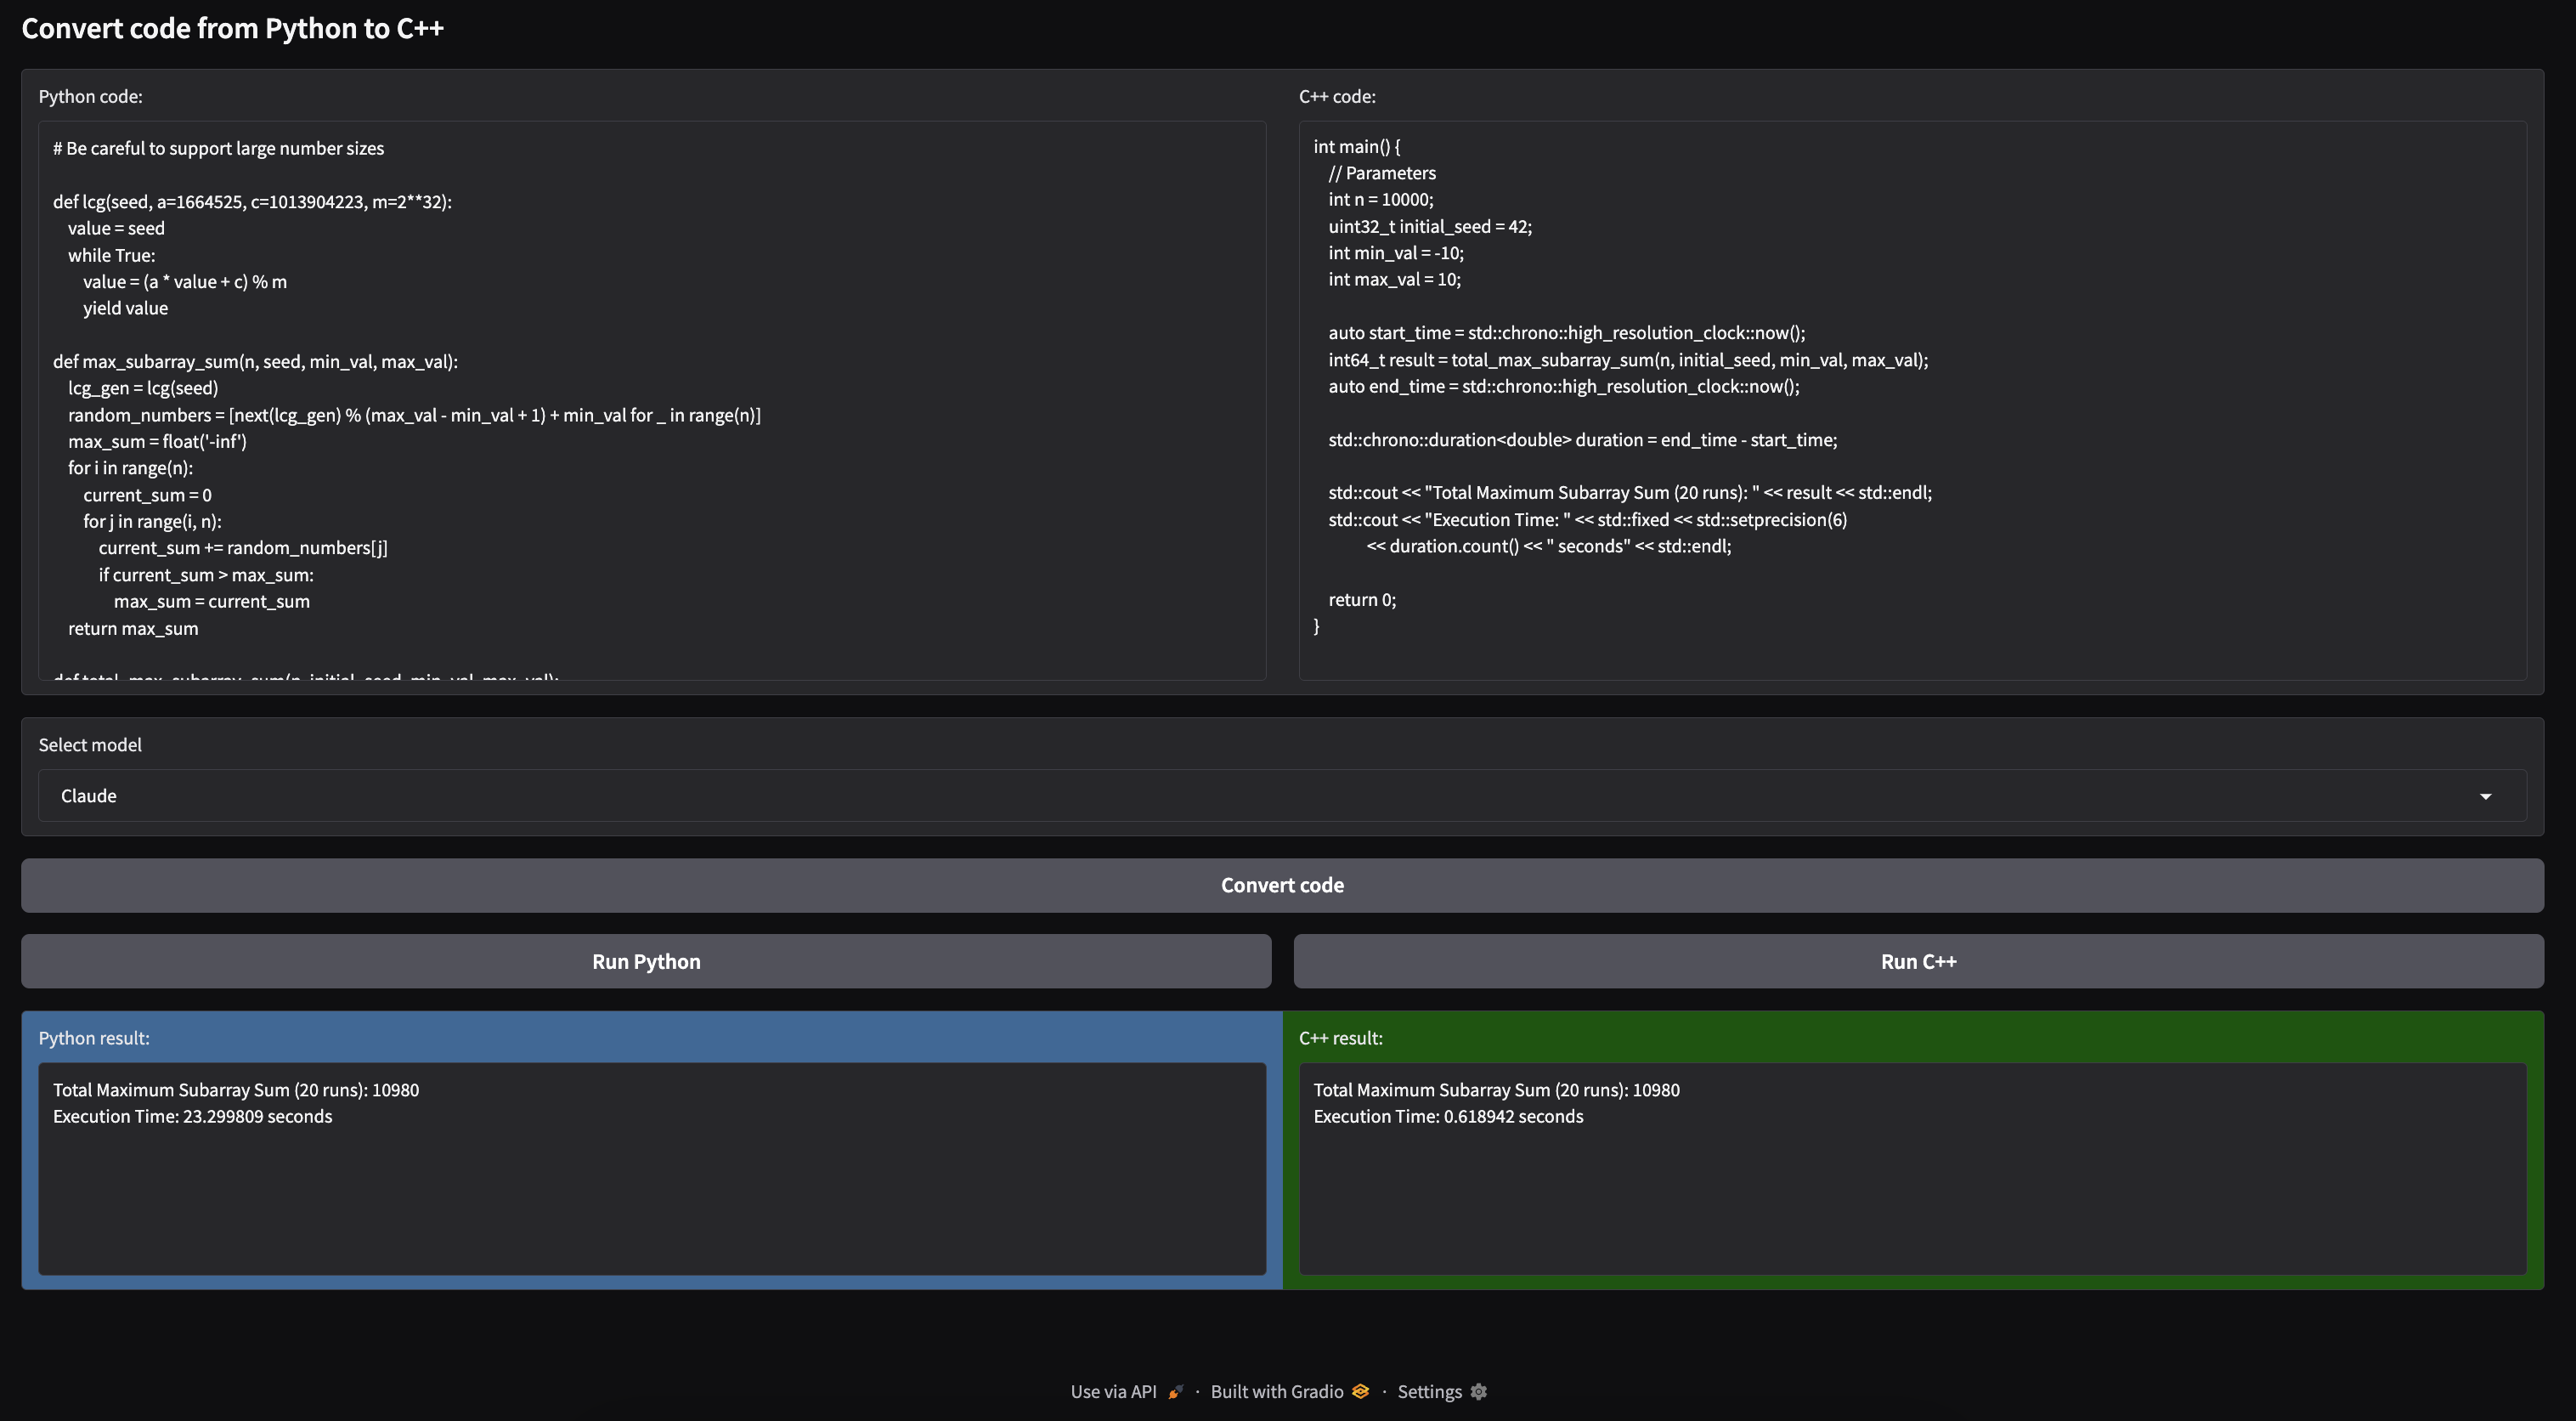

In [54]:
from IPython.display import Image, display

display(Image(filename="/Users/shreyagupta/projects/deep-llm-engineering/images/convert_python_code.png"))